# 2015년 백화점 매출 관련
- 상품-연령별, 상품-거주지역별 분석
- 젊은세대, 특히 25-29 연령대의 매출 증가율이 인상적임
- 명품 구매 증가율도 높음
- 전체 매출에서 유일하게 감소를 기록한 스포츠, 골프 제품에서도 전년 대비 매출 증가를 모임
- 서민백화점이라는 롯데에서 명품, 가전, 스포츠, 골프 등의 매출 증가는 의미가 있음

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cx_Oracle

from matplotlib import rc    # 기본 폰트 설정
rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

db = cx_Oracle.connect('c##lm', 'lm', 'localhost:1521/xe')
cursor = db.cursor()

In [ ]:
# 2015-2015 전체 매출 비교
import cx_Oracle; import pandas as pd

db = cx_Oracle.connect('c##lm', 'lm', 'localhost:1521/xe')
cursor = db.cursor()
cursor.execute('''select 제휴사,
TO_CHAR(sum(구매금액), 'FM999,999,999,999') 구매금액,
TO_CHAR(SUM(CASE WHEN 구매일자 LIKE '2014%' THEN 구매금액 END), 'FM999,999,999,999') AS "2014년", 
TO_CHAR(SUM(CASE WHEN 구매일자 LIKE '2015%' THEN 구매금액 END), 'FM999,999,999,999') AS "2015년",
TO_CHAR(SUM(CASE WHEN 구매일자 LIKE '2015%' THEN 구매금액 END) - SUM(CASE WHEN 구매일자 LIKE '2014%' THEN 구매금액 END), 'FM999,999,999,999') AS 증감액,
TO_CHAR((SUM(CASE WHEN 구매일자 LIKE '2015%' THEN 구매금액 END) - SUM(CASE WHEN 구매일자 LIKE '2014%' THEN 구매금액 END)) / SUM(CASE WHEN 구매일자 LIKE '2014%' THEN 구매금액 END) * 100, 'FM999,999,999.9') || '%' AS 증감율
FROM purprod
group by 제휴사
order by 제휴사''')
x = cursor.fetchall()
# 커서 설명을 사용하여 열 이름을 가져옵니다
col_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(x, columns=col_names)    # 이거 없어도 됨 -> [:5] - 첫 5개의 열 이름만 사용
df.head()

,제휴사,구매금액,2014년,2015년,증감액,증감율
0,A,"514,841,144,030","249,107,710,200","265,733,433,830","16,625,723,630",6.7%
1,B,"111,221,686,478","56,370,935,091","54,850,751,387","-1,520,183,704",-2.7%
2,C,"50,060,970,889","23,810,993,186","26,249,977,703","2,438,984,517",10.2%
3,D,"895,355,544","312,202,104","583,153,440","270,951,336",86.8%


# 대분류상품분석 (백화점 옛날 층수인 것 같기도 하고 아닌 것 같기도 함)
- 01 - '식품관', 일용잡화, 육류, 축산가공, 농산물, 수산품, 가공식품 등
- 02 - '잡화\n화장품\n액세서리', 액세서리, 화장품, 피혁잡화, 구두, 섬유잡화 등
- 03 - '아동',
- 04 - '의류\n(영플라자)', 캐주얼(영플라자 포함), 디자이너의류, 란제리, 내의, 시티웨어, 커리어 등
- 05 - '남성의류',
- 06 - '스포츠\n골프',
- 07 - '가전',
- 08 - '명품',
- 09 - '리빙'


In [ ]:
# 대분류코드 매출 순위
cursor.execute('''
select 대분류코드, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액")-sum("2014구매금액") 전년도_대비_매출액,
CASE WHEN SUM("2014구매금액") = 0 THEN 0
    ELSE round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) END AS 증감율
from year_pur_demo where 제휴사 = 'A' group by 대분류코드
order by 구매금액 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_prod_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_prod_sales

,대분류코드,구매금액,2014구매금액,2015구매금액,전년도_대비_매출,증감율
0,4,150359723590,73310139160,77049584430,3739445270,5.10
1,2,77012441130,38442309700,38570131430,127821730,0.33
2,1,65550240880,31720975170,33829265710,2108290540,6.65
3,8,64602297810,28803579870,35798717940,6995138070,24.29
4,6,45911721700,23556076800,22355644900,-1200431900,-5.10
5,9,32954674300,15659573750,17295100550,1635526800,10.44
6,5,32861877920,16200144790,16661733130,461588340,2.85
7,7,28812407380,13108496520,15703910860,2595414340,19.80
8,3,16775759320,8306414440,8469344880,162930440,1.96


In [ ]:
df_prod_sales['대분류코드'] = df_prod_sales['대분류코드'].astype(str)

def get_x_labels(code):
    x_labels = {
        '1': '1식품관',
        '2': '2잡화\n화장품\n액세서리',
        '3': '3아동',
        '4': '4의류\n(영플라자)',
        '5': '5남성의류',
        '6': '6스포츠\n골프',
        '7': '7가전',
        '8': '8명품',
        '9': '9리빙'
    }
    return x_labels.get(code, '')  # 대분류 코드에 매칭되는 눈금 이름 반환, 없을 경우 빈 문자열 반환

#### 총매출 순위
- 2014년이나 2015년 순위는 안봐도 됨, 전년도_대비_매출로 다 커버됨

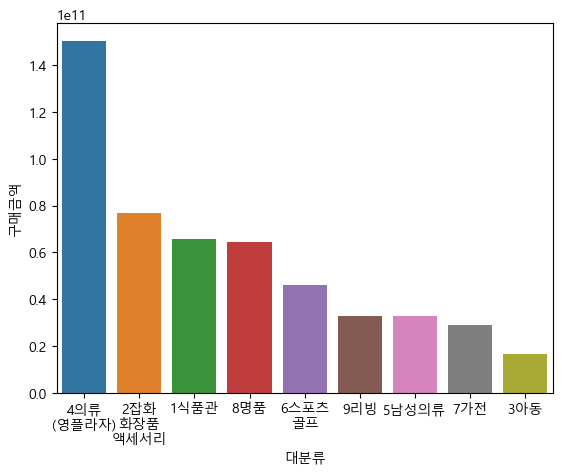

In [ ]:
sns.barplot(data=df_prod_sales, x='대분류코드', y='구매금액')
plt.xlabel('대분류')
plt.ylabel('구매금액')

# x축 눈금 라벨 변경
plt.xticks(range(len(df_prod_sales['대분류코드'].unique())), [get_x_labels(str(code)) for code in df_prod_sales['대분류코드'].unique()])

plt.show()

#### 증감율 순위

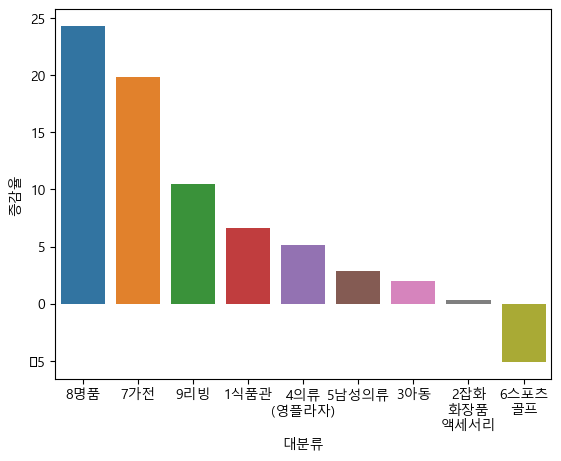

In [ ]:
sorted_df = df_prod_sales.sort_values('증감율', ascending=False)

sns.barplot(data=sorted_df, x='대분류코드', y='증감율')
plt.xlabel('대분류')
plt.ylabel('증감율')

# x축 눈금 라벨 변경
plt.xticks(range(len(sorted_df['대분류코드'].unique())), [get_x_labels(str(code)) for code in sorted_df['대분류코드'].unique()])

plt.show()

#### 전년도_대비_매출 순위

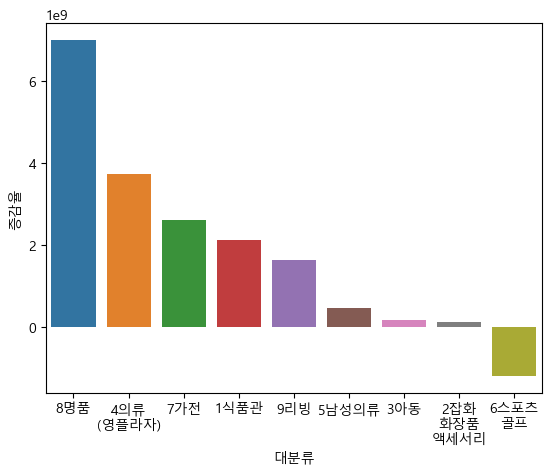

In [ ]:
sorted_df = df_prod_sales.sort_values('전년도_대비_매출액', ascending=False)

sns.barplot(data=sorted_df, x='대분류코드', y='전년도_대비_매출액')
plt.xlabel('대분류')
plt.ylabel('증감율')

# x축 눈금 라벨 변경
plt.xticks(range(len(sorted_df['대분류코드'].unique())), [get_x_labels(str(code)) for code in sorted_df['대분류코드'].unique()])

plt.show()

# 연령대별 분석

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' group by 연령대 order by 연령대
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

#### 매출 순위

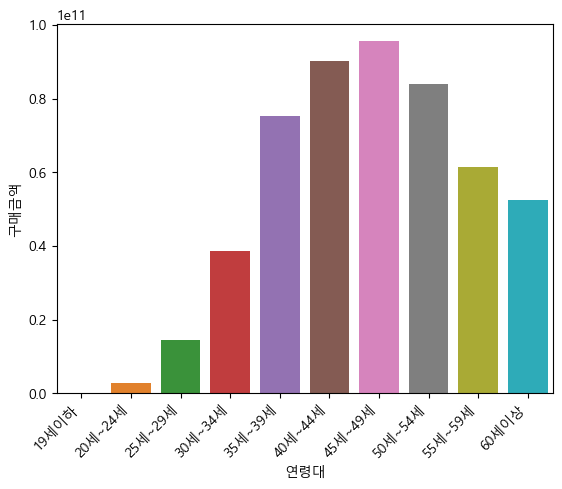

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='구매금액')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('구매금액')
plt.show()

#### 전년도 대비 증감율 - 25~29세 53% 백화점 매출 증가
- 25~29 연령대 백화점 매출 증가가 인상적임

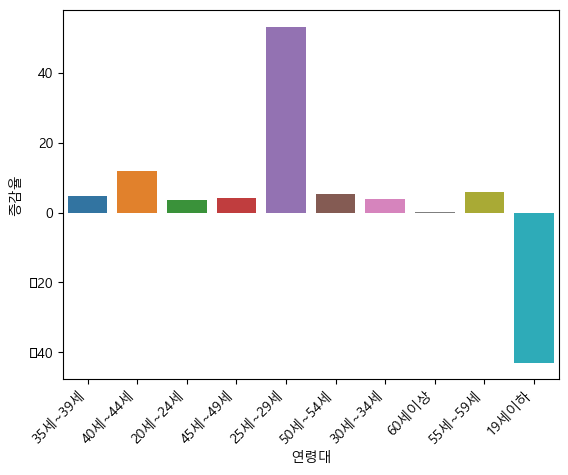

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 25~29세 제휴사별 매출 추이

In [ ]:
cursor.execute('''
select 제휴사, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 연령대='25세~29세' group by 제휴사 order by 제휴사
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_2529age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_2529age_sales

,제휴사,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,A,5669289450,8687108960,3017819510,53.23
1,B,1493185265,1655476477,162291212,10.87
2,C,402376724,445869117,43492393,10.81
3,D,95145950,176528730,81382780,85.53


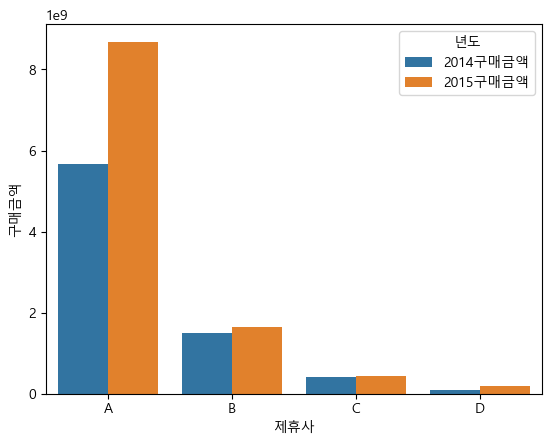

In [ ]:
df_2529age_sales.drop(['전년도_대비_매출액', '증감율'], axis=1, inplace=True)

df_2529age_sales_melted = df_2529age_sales.melt(id_vars='제휴사', var_name='년도', value_name='구매금액')

# 그래프 그리기
sns.barplot(data=df_2529age_sales_melted, x='제휴사', y='구매금액', hue='년도')
plt.xlabel('제휴사')
plt.ylabel('구매금액')

plt.show()

#### 대분류코드 08 (명품) 매출
- 20대 젊은층의 명품 매출 증가폭 큼

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=08 group by 연령대 order by 연령대
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

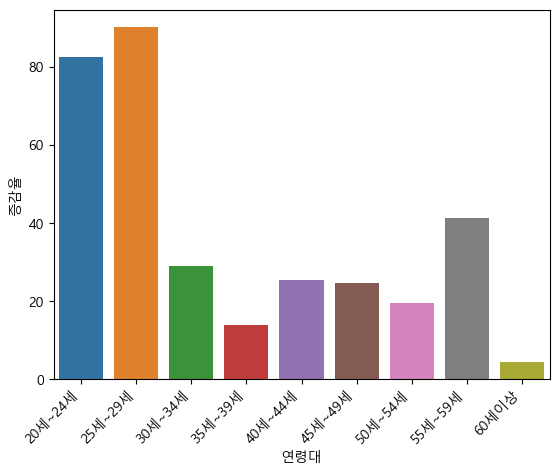

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 대분류코드 07 (가전) 매출

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=07 group by 연령대 order by 전년도_대비_매출액 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,35세~39세,4528304890,1860486220,2667818670,807332450,43.39
1,45세~49세,4771052030,2138737670,2632314360,493576690,23.08
2,50세~54세,4561916690,2040730810,2521185880,480455070,23.54
3,40세~44세,4557342510,2144695780,2412646730,267950950,12.49
4,55세~59세,3968577240,1867586180,2100991060,233404880,12.50
5,60세이상,4149454770,1992812420,2156642350,163829930,8.22
6,25세~29세,360380320,139093120,221287200,82194080,59.09
7,20세~24세,86675060,23086760,63588300,40501540,175.43
8,30세~34세,1828255870,900848560,927407310,26558750,2.95
9,19세이하,448000,419000,29000,-390000,-93.08


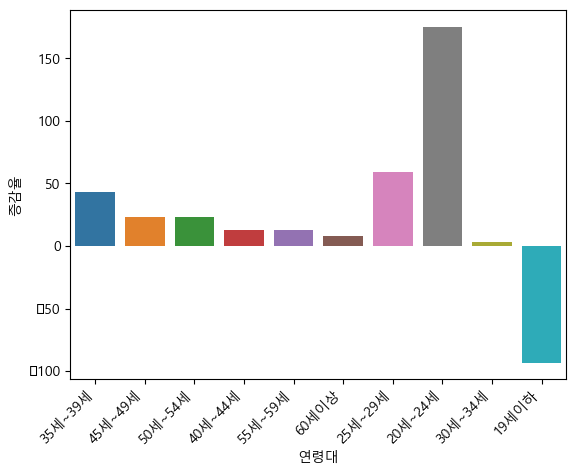

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 대분류코드 06 (스포츠, 골프) 매출
- 전체적인 매출 감소에도 불구하고
- 20대 젊은 연령층의 매출은 증가율을 보임

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=06 group by 연령대 order by 전년도_대비_매출액
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,30세~34세,3881002590,2205363680,1675638910,-529724770,-24.02
1,55세~59세,5441087230,2828718590,2612368640,-216349950,-7.65
2,50세~54세,7413665570,3812111450,3601554120,-210557330,-5.52
3,35세~39세,6099757510,3134062420,2965695090,-168367330,-5.37
4,60세이상,4528791910,2341175260,2187616650,-153558610,-6.56
5,40세~44세,8209099260,4133269580,4075829680,-57439900,-1.39
6,19세이하,14350700,11842600,2508100,-9334500,-78.82
7,45세~49세,9114592490,4548780330,4565812160,17031830,0.37
8,20세~24세,246572880,95925650,150647230,54721580,57.05
9,25세~29세,962801560,444827240,517974320,73147080,16.44


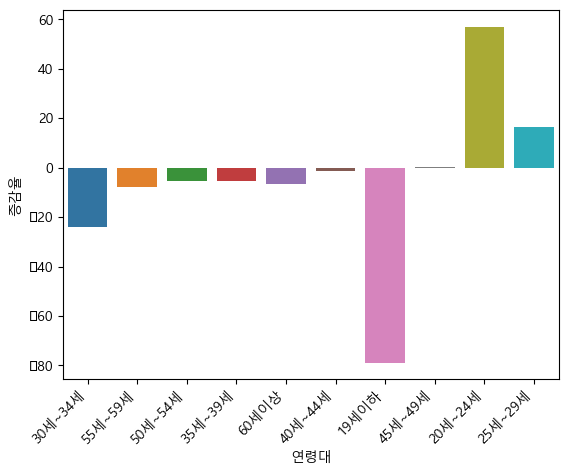

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 대분류코드 09 (리빙) 매출
- 주방용품, 문구/팬시, 생활잡화, 식기, 가구, 침구/수예, 웨딩

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=09 group by 연령대 order by 증감율
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,19세이하,1210800,1120000,90800,-1029200,-91.89
1,40세~44세,5664941290,2873691250,2791250040,-82441210,-2.87
2,45세~49세,6005904030,2955535490,3050368540,94833050,3.21
3,60세이상,3730978790,1778053930,1952924860,174870930,9.83
4,55세~59세,4386023590,2041972130,2344051460,302079330,14.79
5,20세~24세,58716180,27306220,31409960,4103740,15.03
6,35세~39세,4120137980,1909632540,2210505440,300872900,15.76
7,30세~34세,2240831920,1033536150,1207295770,173759620,16.81
8,50세~54세,6199233380,2805199780,3394033600,588833820,20.99
9,25세~29세,546696340,233526260,313170080,79643820,34.10


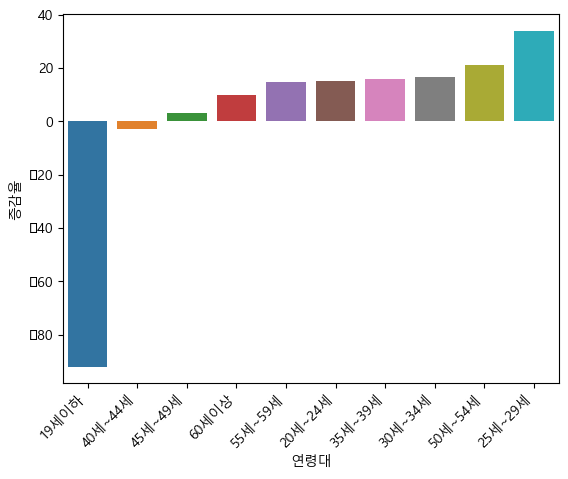

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 대분류코드 04 (의류, 영플라자) 매출

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=04 group by 연령대 order by 증감율 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,25세~29세,5190435330,1730204020,3460231310,1730027290,99.99
1,20세~24세,488157250,218243210,269914040,51670830,23.68
2,40세~44세,25070630380,11285553870,13785076510,2499522640,22.15
3,19세이하,7894970,3704000,4190970,486970,13.15
4,35세~39세,23658723420,11515100860,12143622560,628521700,5.46
5,30세~34세,9737482340,4787467830,4950014510,162546680,3.40
6,50세~54세,26096690290,13047664970,13049025320,1360350,0.01
7,55세~59세,17764368820,8949831380,8814537440,-135293940,-1.51
8,45세~49세,27463248000,14076619220,13386628780,-689990440,-4.90
9,60세이상,14882092790,7695749800,7186342990,-509406810,-6.62


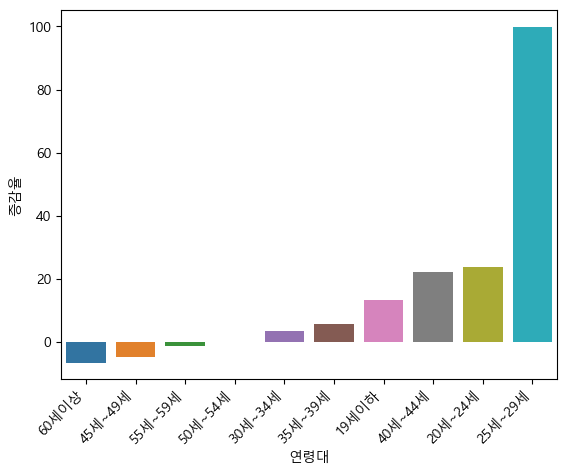

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 대분류코드 02 (잡화, 화장품, 액세서리) 매출

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=02 group by 연령대 order by 증감율 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,19세이하,4112560,1911960,2200600,288640,15.10
1,40세~44세,12791654170,6195196390,6596457780,401261390,6.48
2,45세~49세,14527726960,7103113500,7424613460,321499960,4.53
3,25세~29세,2241686260,1096376320,1145309940,48933620,4.46
4,55세~59세,9036289060,4493515090,4542773970,49258880,1.10
5,50세~54세,12952768800,6468310270,6484458530,16148260,0.25
6,60세이상,6999330250,3498875910,3500454340,1578430,0.05
7,30세~34세,6578082610,3288739550,3289343060,603510,0.02
8,35세~39세,10711872220,5630241710,5081630510,-548611200,-9.74
9,20세~24세,1168918240,666029000,502889240,-163139760,-24.49


#### 대분류코드 05 (남성의류) 매출

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=05 group by 연령대 order by 증감율 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,25세~29세,911010000,373167110,537842890,164675780,44.13
1,50세~54세,6253621060,3036038040,3217583020,181544980,5.98
2,40세~44세,5316921520,2621439120,2695482400,74043280,2.82
3,30세~34세,2293581000,1134384820,1159196180,24811360,2.19
4,45세~49세,6413497070,3189080410,3224416660,35336250,1.11
5,35세~39세,4299657670,2143012310,2156645360,13633050,0.64
6,60세이상,2902534430,1450727590,1451806840,1079250,0.07
7,55세~59세,4377726800,2199656520,2178070280,-21586240,-0.98
8,20세~24세,90046770,49920470,40126300,-9794170,-19.62
9,19세이하,3281600,2718400,563200,-2155200,-79.28


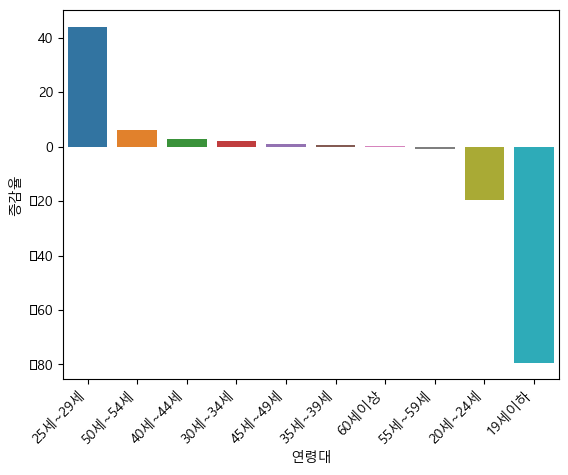

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 대분류코드 01 (식품관) 매출

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=01 group by 연령대 order by 증감율 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,19세이하,9609330,3894880,5714450,1819570,46.72
1,40세~44세,11940468820,5686230060,6254238760,568008700,9.99
2,45세~49세,15395186950,7385083660,8010103290,625019630,8.46
3,30세~34세,4941500640,2378995850,2562504790,183508940,7.71
4,25세~29세,1267505980,611657820,655848160,44190340,7.22
5,60세이상,6456240070,3127881810,3328358260,200476450,6.41
6,35세~39세,7820009560,3812626320,4007383240,194756920,5.11
7,20세~24세,317027020,154970530,162056490,7085960,4.57
8,55세~59세,7227355830,3549401800,3677954030,128552230,3.62
9,50세~54세,10175336680,5010232440,5165104240,154871800,3.09


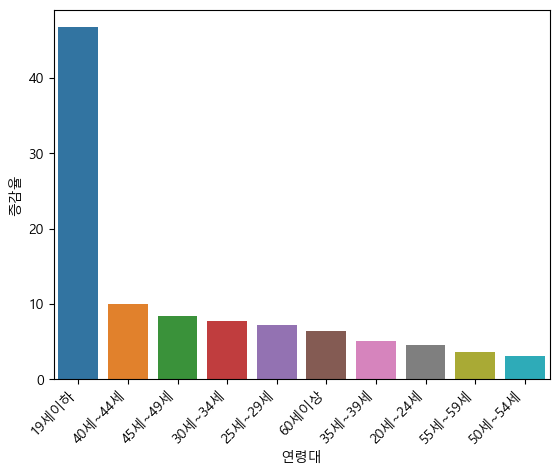

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

#### 대분류코드 03 (아동) 매출

In [ ]:
cursor.execute('''
select 연령대, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액") - sum("2014구매금액") 전년도_대비_매출액,
round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) AS 증감율
from year_pur_demo where 제휴사='A' and 대분류코드=03 group by 연령대 order by 증감율 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_age_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_age_sales

,연령대,구매금액,2014구매금액,2015구매금액,전년도_대비_매출액,증감율
0,20세~24세,18591100,6196180,12394920,6198740,100.04
1,50세~54세,803700140,349100820,454599320,105498500,30.22
2,55세~59세,944211110,446374470,497836640,51462170,11.53
3,30세~34세,2532413660,1205994420,1326419240,120424820,9.99
4,25세~29세,342795770,167577720,175218050,7640330,4.56
5,60세이상,1309252900,643632530,665620370,21987840,3.42
6,40세~44세,3908757830,1967063680,1941694150,-25369530,-1.29
7,35세~39세,5161765370,2624615570,2537149800,-87465770,-3.33
8,45세~49세,1753076310,894663920,858412390,-36251530,-4.05
9,19세이하,1195130,1195130,0,-1195130,-100.00


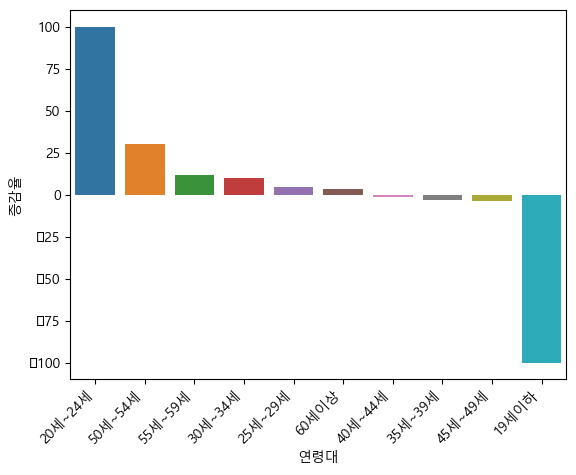

In [ ]:
sns.barplot(data=df_age_sales, x='연령대', y='증감율')
plt.xticks(rotation=45, ha='right')
plt.xlabel('연령대')
plt.ylabel('증감율')
plt.show()

### 거주지역별 분석

In [ ]:
# 대분류코드 매출 순위
cursor.execute('''
select 거주지역, sum(구매금액) 구매금액, sum("2014구매금액") "2014구매금액", sum("2015구매금액") "2015구매금액",
sum("2015구매금액")-sum("2014구매금액") 전년도_대비_매출,
CASE WHEN SUM("2014구매금액") = 0 THEN 0
    ELSE round((SUM("2015구매금액") - SUM("2014구매금액")) / SUM("2014구매금액") * 100, 2) END AS 증감율
from year_pur_demo where 제휴사 = 'A' group by 거주지역
order by 구매금액 desc
''')
x = cursor.fetchall()
col_names = [desc[0] for desc in cursor.description]
df_region_sales = pd.DataFrame(x, columns=col_names)

In [ ]:
df_region_sales

,거주지역,구매금액,2014구매금액,2015구매금액,전년도_대비_매출,증감율
0,100,141157477100,68596223750,72561253350,3965029600,5.78
1,460,71631760100,35407067700,36224692400,817624700,2.31
2,055,51221635260,24478543900,26743091360,2264547460,9.25
3,500,31144984260,15365612870,15779371390,413758520,2.69
4,060,28070949210,13776048210,14294901000,518852790,3.77
5,016,24903260200,11687008780,13216251420,1529242640,13.08
6,210,14871368130,6947469100,7923899030,976429930,14.05
7,610,13074113210,6410612320,6663500890,252888570,3.94
8,540,11689046270,5585969170,6103077100,517107930,9.26
9,024,11302133020,4612179400,6689953620,2077774220,45.05


<AxesSubplot:xlabel='거주지역', ylabel='구매금액'>

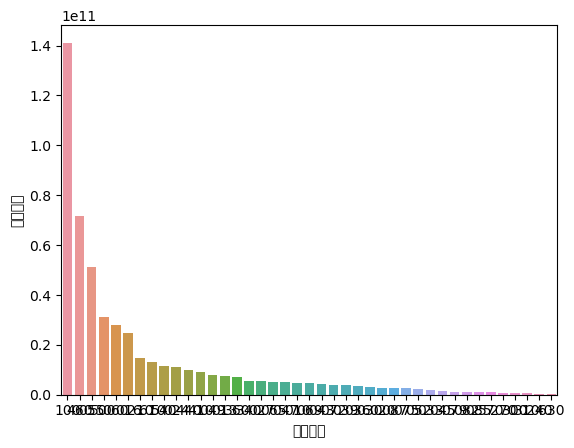

In [ ]:

sns.barplot(data=df_region_sales, x='거주지역', y='구매금액')

<AxesSubplot:xlabel='거주지역', ylabel='2015구매금액'>

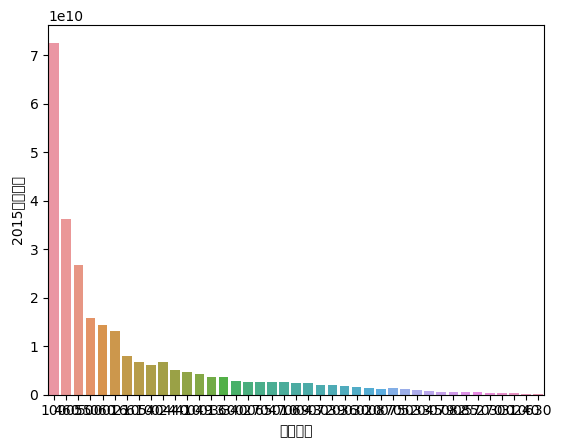

In [ ]:

sns.barplot(data=df_region_sales, x='거주지역', y='2015구매금액')